In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

Variational E Step for lambda

In [75]:
def mean_field(X, mu_ES, mu_ESS, sigma, pie, lambda0, maxsteps):
    """
    -- lambda0 is N x K
    -- F is lower bound on likelihood
    -- X is N x D data matrix 
    -- mu_ES is D x K matrix of means
    -- pie is 1 x K vector of priors
    """
    N, D = X.shape
    K = mu_ES.shape[1]
    Lambda = lambda0.copy()
    f = []
    eps = 1
    cIter = 0
    constant = 1e-15

    while abs(eps) > 1e-15 and cIter <= maxsteps:
        
        Lambda[np.isclose(Lambda, 0)] = constant
        Lambda[np.isclose(Lambda, 1)] = 1 - constant
        
        term_1 = np.sum(np.multiply(Lambda, np.log(pie/Lambda)))
        term_2 = np.sum(np.multiply((1-Lambda), np.log((1-pie)/(1-Lambda))))
        term_3 = -N*D*np.log(sigma)
        weights = (X - Lambda @ mu_ES.T)
        term_4 = -np.trace((2*sigma**2)**-1*(weights @ weights.T))
        term_5 = -np.sum((2*sigma**2)**-1*(Lambda - Lambda**2) @ np.diag(mu_ESS))
        term_6 = -N*(D/2)*np.log(2*np.pi)
        f_ = np.sum(term_1 + term_2 + term_3 + term_4 + term_5 + term_6)

        if(cIter > 0):
            eps = f_ - f[cIter - 1]
        f.append(f_)
        
        cIter += 1
        
        for i in range(K):
            term_1 = np.repeat(np.log(pie[:,i])-np.log((1-pie[:,i])), N)
            weight = np.delete(Lambda, i, 1) @ np.delete(mu_ES, i, 1).T
            term_2 = (sigma**-2)*(X - weight) @ mu_ES[:,i]
            term_3 = -np.repeat(1/(2*sigma**2)*mu_ESS[i], N)
            Lambda[:,i] = sigmoid(term_1 + term_2 + term_3)
                
    return Lambda, f[-1], f

Variational M-step

In [76]:
def m_step(X, ES, ESS, mu_ES, mu_ESS):
    """
    mu, sigma, pie = MStep(X,ES,ESS)

    Inputs:
    -----------------
           X: shape (N, D) data matrix
          ES: shape (N, K) E_q[s]
         ESS: shape (K, K) sum over data points of E_q[ss'] (N, K, K)
                           if E_q[ss'] is provided, the sum over N is done for you.

    Outputs:
    --------
          mu: shape (D, K) matrix of means in p(y|{s_i},mu,sigma)
       sigma: shape (,)    standard deviation in same
         pie: shape (1, K) vector of parameters specifying generative distribution for s
    """
    N, D = X.shape
    if ES.shape[0] != N:
        raise TypeError('ES must have the same number of rows as X')
    K = ES.shape[1]
    if ESS.shape == (N, K, K):
        ESS = np.sum(ESS, axis=0)
    if ESS.shape != (K, K):
        raise TypeError('ESS must be square and have the same number of columns as ES')
    
    t_1 = np.trace(np.dot(X.T, X))
    t_2 =  np.trace(np.dot(np.dot(mu_ES.T, mu_ES), ESS))
    t_3 = - np.dot(np.dot(mu_ES.T, mu_ES).diagonal(), (ESS.diagonal()))
    t_4 = np.dot(mu_ESS, ESS.diagonal())
    t_5 = -2*np.trace(np.dot(np.dot(ES.T, X), mu_ES))
    sigma = np.sqrt((t_1 + t_2 + t_3 + t_4 + t_5)/(N*D))
    
    sigma = np.sqrt((np.trace(np.dot(X.T, X)) + \
                    np.trace(np.dot(np.dot(mu_ES.T, mu_ES), ESS)) \
                     - np.dot(np.dot(mu_ES.T, mu_ES).diagonal(), (ESS.diagonal())) \
                     + np.dot(mu_ESS, ESS.diagonal()) \
                      - 2*np.trace(np.dot(np.dot(ES.T, X), mu_ES))) / (N * D))

    
    pie = np.mean(ES, axis=0, keepdims=True)
    
    return sigma, pie

ESS function

In [77]:
def compute_ESS(Lambda):
    """
    Computes E_q[ss'] (N, K, K), using Lambda matrix.
    """
    
    N, K = Lambda.shape
    ESS = np.zeros(shape=(N,K,K))
    
    for n in range(N):
        
        lambda_n = Lambda[n,:]
        
        for k_1 in range(K):
            
            for k_2 in range(K):
                
                ESS[n,k_1,k_2] = lambda_n[k_1]*lambda_n[k_2]
        
        diag = lambda_n - lambda_n**2
                
        ESS[n,:,:] += np.diag(diag)
    
    return ESS

In [78]:
def init_params(N, D, K):
    Lambda = 0.25 + np.random.rand(N,K)/2.0
    mu_ES = 0.25 + np.random.rand(D,K)/2.0
    mu_ESS = 0.25 + np.ones(K)/2.0
    pie = 0.25 + np.random.rand(1,K)*0.5
    sigma = 1
    
    return Lambda, mu_ES, mu_ESS, pie, sigma
    

In [79]:
def compute_moments(X, mu_ES, mu_ESS, ESS, sigma, pie, lambda0, alpha, maxsteps):
    
    # C_ is K vector
    # M_ is D x K
    N, D = X.shape
    D, K = mu_ES.shape

    mu_ESS_ = mu_ESS.copy()
    mu_ES_ = mu_ES.copy()
    ESS_ = np.sum(ESS, axis = 0)
    
    C_ = (1/sigma**2 * np.sum(lambda0, axis = 0) + alpha)**(-1)
    
    for step in range(maxsteps):
        
        for i in range(K):
            
            t_1 = X.T @ lambda0[:, i][:, None] 
          
            temp = np.hstack((lambda0[:, :i], lambda0[:, i+1:])).T @ lambda0[:, i][:, None] 
   
            t_2 = np.hstack((mu_ES_[:, :i], mu_ES_[:, i+1:])) @ temp
 
            mu_ES_[:, i] = C_[i] * np.squeeze((1/sigma**2)*(t_1 - t_2))
        
    mu_ESS_ = (D * C_ + np.diag(mu_ES_.T @ mu_ES_))

    return mu_ES_, mu_ESS_

In [80]:
def hyper_m(D, mu_ESS):
    
    K = np.size(mu_ESS)
    alpha = np.zeros(K)
    
    for i in range(K):
        alpha[i] = D/(mu_ESS[i])
        
    return alpha

In [81]:
def learn_bin_factors(X, K, iterations):
    
    N, D = X.shape
    Lambda, mu_ES, mu_ESS, pie, sigma = init_params(N,D,K)
    
    alpha_val = 120
    alpha = np.ones(K)*alpha_val
    THRESHOLD = alpha_val*10
    maxsteps = 30
    free_energies = []
    alphas = []
    nfactors = np.zeros(iterations)
    
    ESS = compute_ESS(Lambda)
    mu_ES, mu_ESS = compute_moments(X, mu_ES, [], ESS, sigma, pie, Lambda, alpha, 5)
    
    for cIter in range(iterations):
        
        
        Lambda, f, f_l = mean_field(X, mu_ES, mu_ESS, sigma, pie, Lambda, maxsteps)
        free_energies.append(f)
        
        print(f)
        
        ESS = compute_ESS(Lambda)
        mu_ES, mu_ESS = compute_moments(X, mu_ES, mu_ESS, ESS, sigma, pie, Lambda, alpha, 5)
        
        sigma, pie = m_step(X, Lambda, ESS, mu_ES, mu_ESS)
        
        
        alpha = hyper_m(D, mu_ESS)
     #   print('Alphas in iteration {}'.format(cIter))
     #   print(alpha)
        alphas.append(alpha)
        
        factors =  [a for a in alpha if a < THRESHOLD]
        nfactors[cIter] = len(factors)
   #     print(nfactors)
   #     print(alpha)
        
    return mu_ES, sigma, pie, Lambda, free_energies, alphas, nfactors

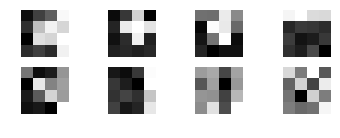

In [82]:
N=400  # number of data points - you can increase this if you want to
       # learn better features (but it will take longer).
D=16   # dimensionality of the data

np.random.seed(0)

# Define the basic shapes of the features

m1 = [0, 0, 1, 0,
      0, 1, 1, 1,
      0, 0, 1, 0,
      0, 0, 0, 0]

m2 = [0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0]

m3 = [1, 1, 1, 1,
      0, 0, 0, 0,
      0, 0, 0, 0,
      0, 0, 0, 0]

m4 = [1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1] 

m5 = [0, 0, 0, 0,
      0, 0, 0, 0,
      1, 1, 0, 0,
      1, 1, 0, 0] 

m6 = [1, 1, 1, 1,
      1, 0, 0, 1,
      1, 0, 0, 1,
      1, 1, 1, 1] 

m7 = [0, 0, 0, 0,
      0, 1, 1, 0,
      0, 1, 1, 0,
      0, 0, 0, 0]

m8 = [0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1]

nfeat = 8 # number of features
rr = 0.5 + np.random.rand(nfeat, 1) * 0.5 # weight of each feature between 0.5 and 1
mut = np.array([rr[0] * m1, rr[1] * m2, rr[2] * m3, rr[3] * m4, rr[4] * m5,
                rr[5] * m6, rr[6] * m7, rr[7] * m8])
s = np.random.rand(N, nfeat) < 0.3 # each feature occurs with prob 0.3 independently 

# Generate Data - The Data is stored in Y
Y = np.dot(s, mut) + np.random.randn(N, D) * 0.1 # some Gaussian noise is added 

nrows = 13
for k in range(8):
    plt.subplot(4, 4, k + 1)
    plt.imshow(np.reshape(Y[k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')

plt.show()

In [112]:
K = 16
iterations = 20

free_energy_list = []
effective_factors = []
alpha_list = []
mus = []
K_list = [4,8,12,16,20]
#K_list = [8]
mu = 0
for k in K_list:
    mu, sig, pie, lambda_, free_energies, alphas, nfactors = learn_bin_factors(Y, k, iterations)
    free_energy_list.append(free_energies)
    effective_factors.append(nfactors)
    alpha_list.append(alphas)
    mus.append(mu)

-7144.326808716516
-5357.975308671415
-5160.9396337454355
-4737.861225290562
-4208.344746209208
-4013.098725808083
-3965.464583193594
-3935.4438190594983
-3904.757015473144
-3872.1879522122217
-3847.755320529812
-3834.286912594206
-3822.8176257771993
-3808.5843857837376
-3805.0598261543287
-3797.2057070628375
-3789.3037685888185
-3780.5112009940635
-3779.3690576030194
-3778.845345121528
-7019.980248656979
-5345.256740309932
-5061.840180791947
-4681.191648940259
-4271.602333700664
-3710.5406327007904
-3164.259635527361
-2657.695196322428
-2320.4421610370628
-1969.5428783252091
-1759.0762781697058
-1642.0621807795187
-1577.605256242019
-1491.3191788190106
-1440.7960439928402
-1423.662048804229
-1418.3158788328083
-1413.513511115495
-1410.837557489016
-1408.8300784305693
-7021.396380971968
-5392.294454552389
-5060.422804052901
-4808.96324093021
-4366.52591689099
-3897.8397932372673
-3488.2282449840945
-3093.1118654935517
-2841.709254710946
-2614.45284578274
-2367.159235090922
-2044.986892

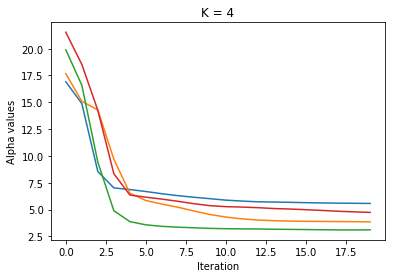

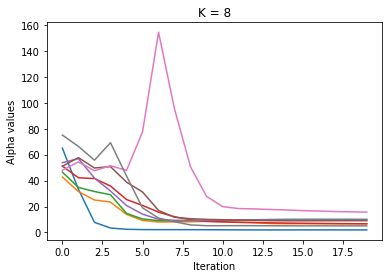

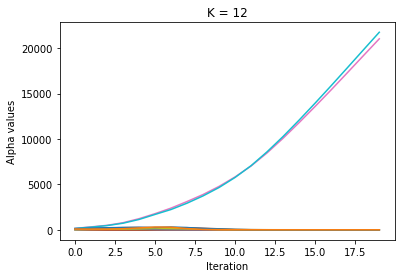

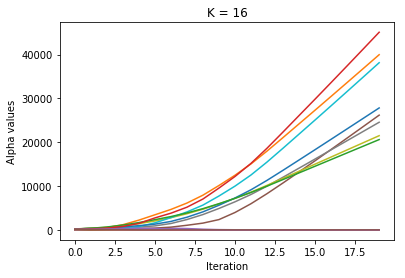

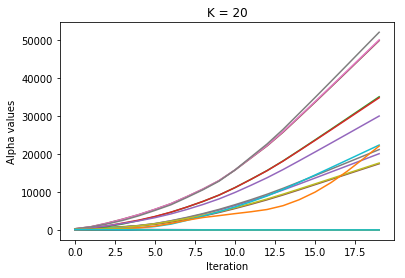

In [113]:
for i in range(len(K_list)):
    plt.plot(alpha_list[i])
    plt.title('K = {}'.format(K_list[i]))
    plt.ylabel('Alpha values')
    plt.xlabel('Iteration')
    plt.show()

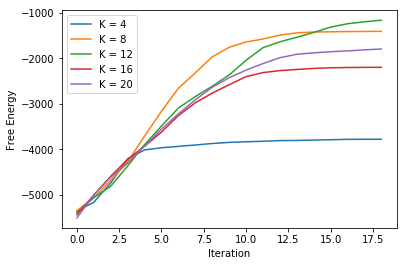

In [114]:
for i in range(len(K_list)):
    plt.plot(free_energy_list[i][1:], label = 'K = {}'.format(K_list[i]))
    plt.ylabel('Free Energy')
    plt.xlabel('Iteration')
    plt.legend()

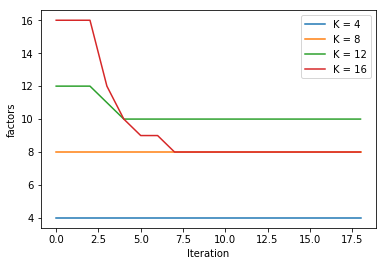

In [115]:
for i in range(len(K_list)-1):
    plt.plot(effective_factors[i][1:], label = 'K = {}'.format(K_list[i]))
    plt.ylabel('factors')
    plt.xlabel('Iteration')
    plt.legend()

In [109]:
mu_curr = np.array(mus[1])


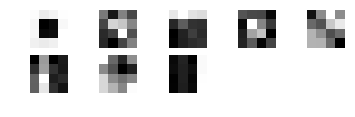

In [110]:
for k in range(mu_curr.shape[1]):
    plt.subplot(5, 5, k + 1)
    plt.imshow(np.reshape(mu_curr[:,k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.show()